In [1]:
#!/usr/bin/env python3.7
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import timeit
from datetime import date
import seaborn as sns

import statsmodels.api as sm

from scipy import stats
import scipy as scipy

import svgutils.transform as sg
import sys

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)  # Give us all the columns without truncation    

In [2]:
def importCSV(filePath):
    dataFrame = pd.read_csv(filePath, header=0, low_memory=False)
    return dataFrame

def reIndex(DF):
    DF.reset_index(drop=True, inplace=True)
    return 0

def nullDrop(DF,col):
    return DF.dropna(subset=col)

def dfDrop(DF,col,inPlace):
    if(inPlace):
        DF.drop(col, inplace=True, axis=1)
        return 0
    else:
        return DF.drop(col,axis=1)

def makeDict(value,key):
    myDict = value
    myDict.index = key
    return myDict.to_dict()


def normaliseDF(DF):
    columns = list(DF) 
    for i in columns:
        DF[i] = DF[i]/DF[i].max()
    return DF

In [175]:
####################################### Dataframes ##########################################################

paidGames = importCSV('data/processed/paidGames.csv')  #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days
freeGames = importCSV('data/processed/freeGames.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days

#paidDLC = importCSV('data/processed/paidDLC.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days
#freeDLC = importCSV('data/processed/freeDLC.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days

#paidMods = importCSV('data/processed/paidMods.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days
#freeMods = importCSV('data/processed/freeMods.csv') #appid  Rating  type  Price  Units_Sold  Total_Revenue  playtime_2weeks playtime_forever  store_time_days

#gameLocPriceCount = importCSV('data/processed/gameLocPriceCount.csv') #Country  Total_Revenue  Revenue_Per_Player
#gameLocPriceCountTop = importCSV('data/processed/gameLocPriceCountTop.csv') # Country  Total_Revenue  Revenue_Per_Player

#playerCountriesCount = importCSV('data/processed/playerCountriesCount.csv') #Country Percentage of Players

socialData = importCSV('data/processed/socialData.csv') #steamid  daysOld  Number_Friends  Number_Groups  Mult_Play_2Week  Mult_Play_All  NonMult_Play_2Week  NonMult_Play_All 

#games = importCSV('data/processed/games.csv') # steamid, appid, playtime_2weeks, playtime_forever, dateretrieved

appInfo = importCSV("data/App_ID_Info.csv") # appid, title, type (game, mod, dlc, hardware etc), Required_Age, Is_multiplayer, Price, Rating

gameWithGenre = importCSV('data/processed/gameWithGenre.csv') #steamid   appid  playtime_2weeks  playtime_forever   genre

playerProfile = importCSV('data/processed/playerProfile.csv') #playerProfile # steamid   appid  playtime_forever  Friends  Rating

#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [4]:
gameSales = pd.concat([paidGames, freeGames])
reIndex(gameSales)

dropCols = ['Rating', 'type' , 'Price' , 'Total_Revenue'] #, 'playtime_2weeks', 'playtime_forever'
dfDrop(gameSales,dropCols,1)
gameSales = nullDrop(gameSales,['playtime_forever'])
gameSales = gameSales[gameSales['Units_Sold']>0]

#gameSales['playtime_forever'] = round(gameSales['playtime_forever'] / gameSales['Units_Sold'])
reIndex(gameSales)


0

In [6]:
######## Normalise playtime_forever within playerProfile

daysOldDict = makeDict(socialData['daysOld'],socialData['steamid'])
playerProfile.insert(5, "daysOld", np.nan)
playerProfile['daysOld'] = playerProfile.steamid.map(daysOldDict).fillna(playerProfile['daysOld'])
playerProfile['norm_Playtime'] = (playerProfile['playtime_forever']/playerProfile['daysOld'])*playerProfile['daysOld'].max()

                                 appid  playtime_2weeks  playtime_forever  \
11              Counter-Strike: Source         711797.0      39859.588023   
1207       The Elder Scrolls V: Skyrim        1074734.0      26004.408191   
0                       Counter-Strike         714691.0      24329.286938   
26    Counter-Strike: Global Offensive        3063182.0      22412.195249   
304   Call of Duty®: Modern Warfare® 2         103385.0      19113.414779   
263        Sid Meier's Civilization® V        1262485.0      18730.791102   
151                        Garry's Mod         837697.0      11491.755328   
22                       Left 4 Dead 2         279598.0      10960.374831   
1068                     Borderlands 2         612786.0       9708.304837   
950   Call of Duty®: Modern Warfare® 3         102320.0       8081.588729   

      store_time_days       genre  
11               5544      Action  
1207             2979         RPG  
0                7005      Action  
26      

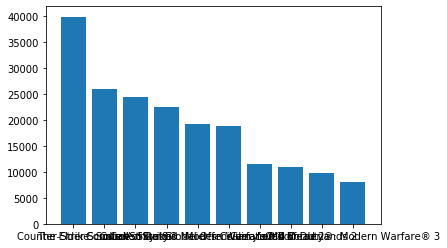

In [226]:
####### TOP GAMES ###########
topVal = 10
gameSales_norm = dfDrop(gameSales,['Units_Sold'],0)
gameSales_norm['playtime_forever'] = gameSales_norm['playtime_forever']/gameSales_norm['store_time_days']
top10_Games = gameSales_norm.nlargest(topVal, 'playtime_forever')
rest_Games = gameSales_norm.nsmallest(gameSales_norm.shape[0]-topVal, 'playtime_forever')

appTitleDict = makeDict(appInfo.Title,appInfo.appid)
#top10_Games['appid'] = top10_Games.appid.map(appTitleDict).fillna(top10_Games['appid'])

plt.bar(top10_Games.appid , top10_Games.playtime_forever)
print(top10_Games)

plt.savefig('top10.svg')
plt.show()
############################

In [19]:
######## Setup vectors for each players with each row corresponding to game played (1/0) and the bottom row
######## denoting the total playtime normalised by age of the player account.

## Take from gameWithGenre # steamid   appid  playtime_2weeks  playtime_forever
## Take from playerProfile # steamid   appid  playtime_forever  Friends  Rating

gameSales = gameSales.sort_values(['appid'], ascending=[True]) 
playerProfile = playerProfile.sort_values(['steamid'], ascending=[True]) 
reIndex(playerProfile)
reIndex(gameSales)
appIDs = np.insert(gameSales.appid.unique(), 0, 0., axis=0)
steamIDs = np.insert(playerProfile.steamid.unique(), 0, 0., axis=0)
numberPlayers =np.unique(playerProfile['steamid']).shape[0]
numberGames = np.unique(gameSales['appid']).shape[0]
myMat = np.zeros((numberPlayers+1,numberGames+1)) # rows, cols
myMat[:,0] = steamIDs
myMat[0,:] = appIDs

myDF = pd.DataFrame(data=myMat[1:,1:],    # values
              index=myMat[1:,0],    # 1st column as index
              columns=myMat[0,1:])  # 1st row as the column names

#semi vectorised apporoach 
for x in range(1,appIDs.shape[0]):
    myDict = makeDict(playerProfile[playerProfile.appid == appIDs[x]]['norm_Playtime'],playerProfile[playerProfile.appid ==  appIDs[x]]['steamid'])
    myDF[appIDs[x]] = myDF.index.to_series().map(myDict).fillna(myDF[appIDs[x]])

myDF['sum'] = myDF.sum(axis=1)

In [ ]:
# Can try and cluster data based on -> steamid, appid, playtime in hours
# games DF contains these.

wcss = []
cluster_max = 15
cluster_min = 4
for i in range(cluster_min, cluster_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(myDF)
    wcss.append(kmeans.inertia_)
    #silhouette_score, really increasing runtime on my machine
    #preds = kmeans.fit_predict(myDF)
    #score = silhouette_score (myDF, preds, metric='euclidean')
    #print ("For n_clusters = {}, silhouette score is {})".format(kmeans.n_clusters, score))

plt.plot(range(cluster_min, cluster_max), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



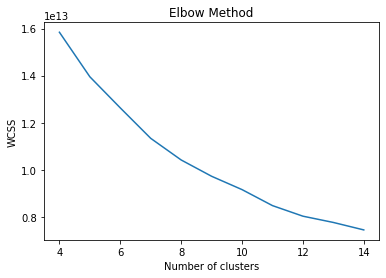

In [98]:
plt.plot(range(cluster_min, cluster_max), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.savefig('elbow.svg')
plt.show()

In [178]:
cluster_optim = 5
kmeans = KMeans(n_clusters=cluster_optim, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(myDF)
myDF['label'] = kmeans.labels_

In [227]:
#to-do, take the 11 abelled steamid and plot heatmaps etc.
#myDF[myDF['label']==1].index.shape # access players in labels

#Lets take the top 10 appids and see how our clustered users behave in these catergories 

print(top10_Games.appid)

myDF_top10 = myDF[myDF.columns.intersection(top10_Games.appid)]
myDF_top10['sum'] = myDF['sum']
myDF_top10.index = myDF['label']
#myDF_top10['label'] = myDF['label']

11                Counter-Strike: Source
1207         The Elder Scrolls V: Skyrim
0                         Counter-Strike
26      Counter-Strike: Global Offensive
304     Call of Duty®: Modern Warfare® 2
263          Sid Meier's Civilization® V
151                          Garry's Mod
22                         Left 4 Dead 2
1068                       Borderlands 2
950     Call of Duty®: Modern Warfare® 3
Name: appid, dtype: object


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [222]:
top10_Games.appid

11        240
1207    72850
0          10
26        730
304     10190
263      8930
151      4000
22        550
1068    49520
950     42690
Name: appid, dtype: int64

In [223]:
myDF_top10_temp = myDF_top10.groupby(['label']).sum()
for i in range(0,cluster_optim):
    myDF_top10_temp.loc[i,:] = myDF_top10_temp.loc[i,:] / myDF_top10_temp.loc[i,'sum']
dfDrop(myDF_top10_temp,['sum'],1)
myDF_top10_temp.head()

,10.0,240.0,550.0,730.0,4000.0,8930.0,10190.0,42690.0,49520.0,72850.0
label,,,,,,,,,,
0,0.072921,0.106717,0.021476,0.022289,0.014108,0.029030,0.032870,0.007612,0.006919,0.033449
1,0.048097,0.098325,0.019973,0.034620,0.021537,0.035304,0.041739,0.014251,0.015208,0.041681
2,0.000275,0.010176,0.008269,0.015393,0.001499,0.001754,0.000267,0.001088,0.000169,0.001529
3,0.079519,0.123019,0.016289,0.049623,0.060195,0.006789,0.032514,0.002473,0.007914,0.010614
4,0.075622,0.073701,0.013050,0.025008,0.017742,0.027728,0.021770,0.009285,0.009001,0.026797


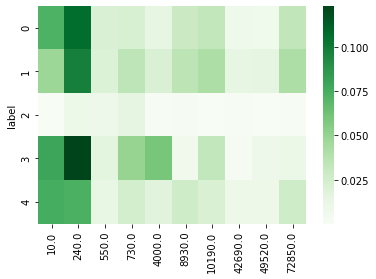

In [225]:
fig, ax = plt.subplots()
HM = sns.heatmap(myDF_top10_temp,cmap="Greens")
figHM = HM.get_figure()
figHM.savefig('heatmapCluster5.svg')

In [102]:

gameSales = gameSales.sort_values(['appid'], ascending=[True])

print(playerProfile.head())

playedVec = pd.DataFrame()


             steamid   appid  playtime_forever  Friends  Rating  daysOld  \
0  76561197971836586  221380             165.0      1.0    68.0   5499.0   
1  76561197971836586     400               0.0      1.0    90.0   5499.0   
2  76561197971836586   10180            1476.0      1.0    86.0   5499.0   
3  76561197971836586     240              14.0      1.0    88.0   5499.0   
4  76561197971836586     220             314.0      1.0    96.0   5499.0   

   norm_Playtime  
0          165.0  
1            0.0  
2         1476.0  
3           14.0  
4          314.0  


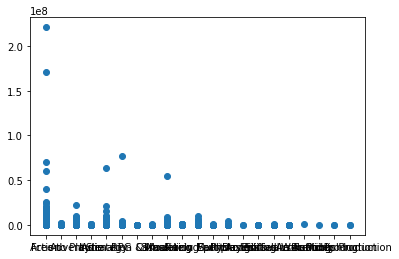

In [108]:
###### Playtime by Genre
gameGenreSales = nullDrop(gameSales,['genre'])
plt.scatter(gameGenreSales['genre'],gameGenreSales['playtime_forever'])
plt.savefig('playtime_genre.svg')
plt.show()

In [127]:
gameGenreSales['playtime_forever'].max

<bound method Series.max of 0       170426655.0
1          498613.0
2         3948441.0
3           56620.0
4          372095.0
           ...     
3362            9.0
3363           52.0
3364          263.0
3365          125.0
3366            0.0
Name: playtime_forever, Length: 3348, dtype: float64>

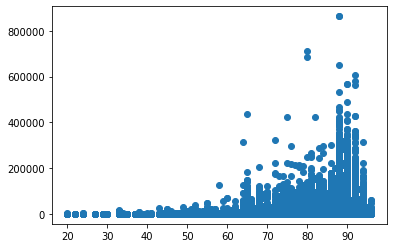

In [126]:
friendsPlayAlltime = dfDrop(playerProfile,['steamid', 'appid', 'Friends'],0) # 'steamid', 'appid', 'Friends'
friendsPlayAlltime = nullDrop(friendsPlayAlltime,['Rating'])
friendsPlayAlltime = nullDrop(friendsPlayAlltime,['playtime_forever'])
friendsPlayAlltime = friendsPlayAlltime[friendsPlayAlltime.Rating > 0]
reIndex(friendsPlayAlltime)

#friendsPlayAlltime['Rating_Binned'] = pd.cut(friendsPlayAlltime['Rating'],
#                     bins=[0, 10, 20, 30,40, 50,60,70,80,90,100],
#                     labels=["0-10", "10-20", "20-30","30-40", "40-50","50-60","60-70","70-80","80-90","90-100"])

#ax = sns.boxplot(y="Rating_Binned",x="playtime_forever", data=friendsPlayAlltime,palette="Set3",orient="h")

plt.scatter(friendsPlayAlltime.Rating,friendsPlayAlltime.playtime_forever)
#fig = ax.get_figure()
#fig.savefig('RatingVsPlayTime.svg')
#plt.savefig('RatingVsPlayTime.svg')
#plt.show()

In [ ]:
print(gameWithGenre.genre.unique())

/Users/Mus/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Mus/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


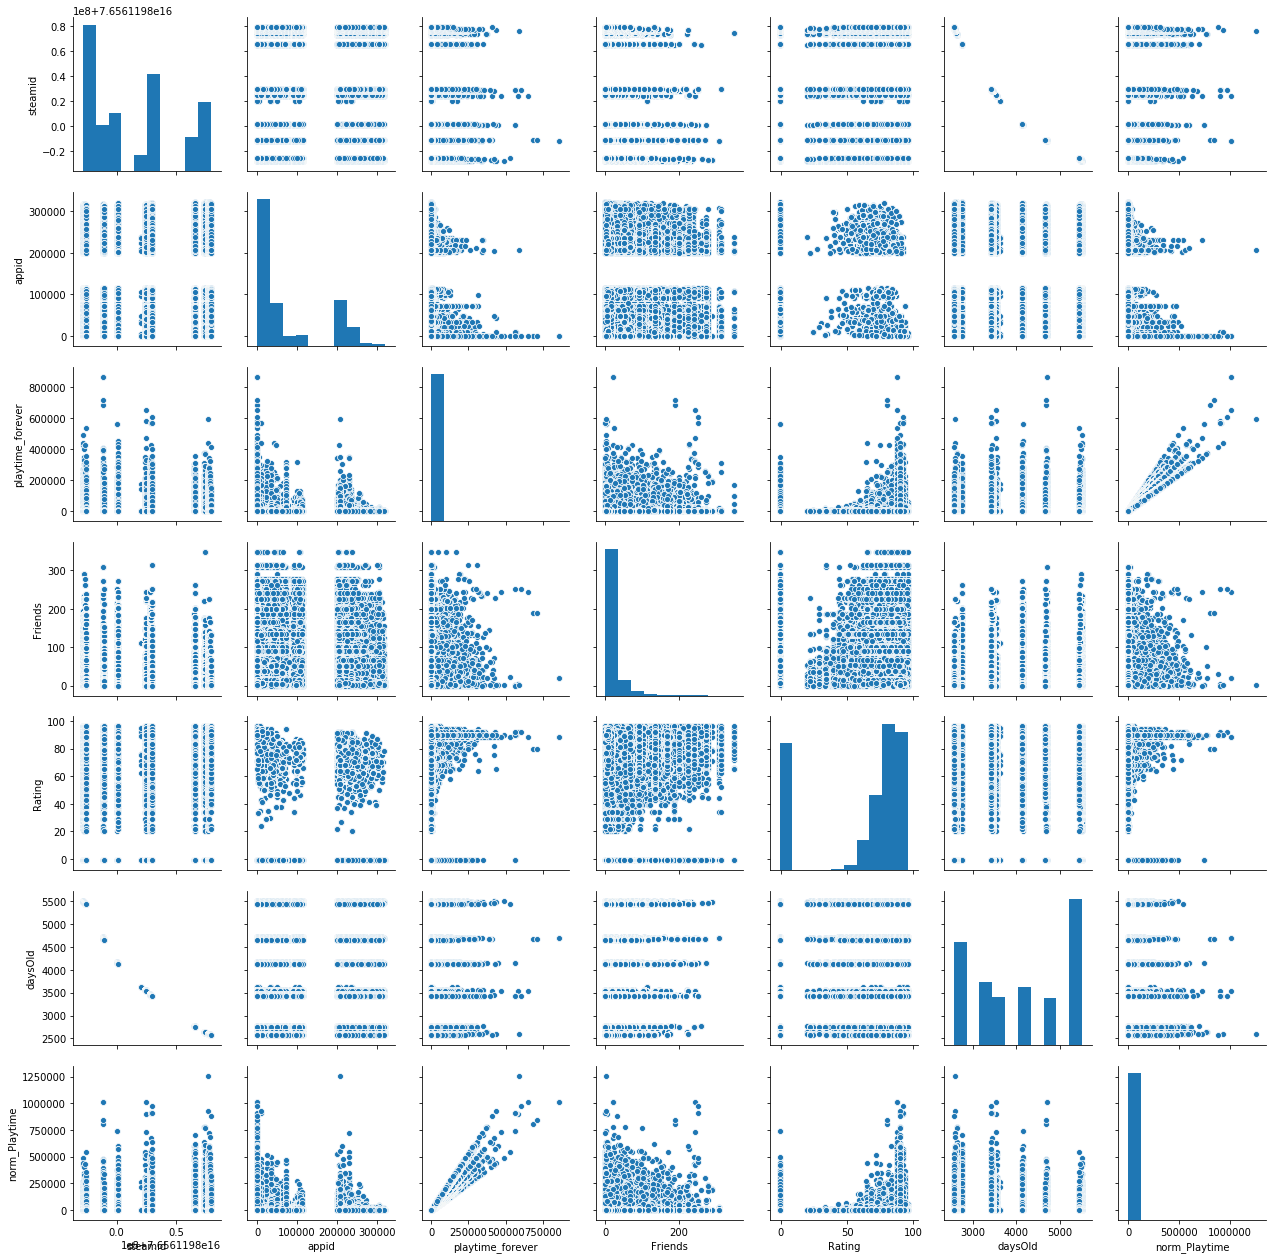

In [107]:
sns.pairplot(playerProfile)

In [177]:
print(appInfo.Title[appInfo.appid==10])

6234    Counter-Strike
Name: Title, dtype: object
